# Creating HAS-model embeddings for entities in a KG
The purpose of these will be for assessing entities' similarities to one another. This measure of similarity between entities will in turn be used to assess the distinctiveness of labels that have previously been created and filtered for this KG.

## Pre-requisite steps to run this notebook
1. You need to run the 1_candidate_label_creation notebook before this notebook.
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [3]:
import os
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter
from h_path_walks import get_h_walks_from_kgtk_item_file
import seaborn as sns

## parameters

**Embedding model parameters**  
*directed*: If true, treat graph as directed when performing H-feature walks. Otherwise undirected.  
*num_H_walks*: Number of random walks to start at each node with the H-feature walk method  
*num_A_walks*: Number of random walks to start at each node with the A-feature walk method  
*num_S_walks*: Number of random walks to start at each node with the S-feature walk method  
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  
*type_to_profile*: Q-node corresponding to the type of entity you want to profile. A and S embedding features will contribute additional information to learn similarities of entities within this type.  
*k*: Used for the A and S feature walks - number of closest neighbors to consider hopping to from a node during a random walk. The paper that this method is based on recommends setting this to ~average degree in the original graph.

**File/Directory parameters**  
*h_walks_file*: Name of file to hold H-feature walks. If this file is already present (e.g. you've run the notebook before), we won't recompute the walks and will just use the ones that are in this file. This is to help avoid accidentally deleting previous work. If you want to re-calculate these, either pick a different file name or manually delete this file.  
*a_walks_file*: Same as h_walks_file parameter except for the A-feature walks.  
*s_walks_file*: Same as h_walks_file parameter except for the S-feature walks.  
*item_file*: File path for the file that contains entity to entity relationships (e.g. wikibase-item).  
*label_file*: File path for the file that contains wikidata labels.  
*time_file*: file path for the file that contains entity to time-type values  
*quantity_file*: file path for the file that contains entity to quantity-type values  
*work_dir*: same work_dir that you specified in the label creation notebook. We'll look for files created by that notebook here. Files created by this notebook will also be saved here.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [28]:
# Embedding model params
directed = False
num_H_walks = 10
num_A_walks = 10
num_S_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32
type_to_profile = "Q11424"
k = 5


# File/Directory params

h_walks_file = "h_walks.txt"
a_walks_file = "a_walks.txt"
s_walks_file = "s_walks.txt"


# item_file = "../../Q44/data/Q44.part.wikibase-item.tsv"
# label_file = "../../Q44/data/Q44.label.en.tsv"
# time_file = "../../Q44/data/Q44.part.time.tsv"
# quantity_file = "../../Q44/data/Q44.part.quantity.tsv"
# work_dir = "../../Q44/profiler_work"
# store_dir = "../../Q44"

# item_file = "../../Q154/data/claims.wikibase-item.tsv.gz"
# label_file = "../../Q154/data/labels.en.tsv.gz"
# time_file = "../../Q154/data/claims.time.tsv.gz"
# quantity_file = "../../Q154/data/claims.quantity.tsv.gz"
# work_dir = "../../Q154/profiler_work"
# store_dir = "../../Q154"

item_file = "../../wikidata_films/data/claims.wikibase-item.tsv.gz"
label_file = "../../wikidata_films/data/labels.en.tsv.gz"
time_file = "../../wikidata_films/data/claims.time.tsv.gz"
quantity_file = "../../wikidata_films/data/claims.quantity.tsv.gz"
work_dir = "../../wikidata_films/profiler_work"
store_dir = "../../wikidata_films"

# item_file = "../../wikidata_politicians/data/claims.wikibase-item.tsv.gz"
# label_file = "../../wikidata_politicians/data/labels.en.tsv.gz"
# time_file = "../../wikidata_politicians/data/claims.time.tsv.gz"
# quantity_file = "../../wikidata_politicians/data/claims.quantity.tsv.gz"
# work_dir = "../../wikidata_politicians/profiler_work"
# store_dir = "../../wikidata_politicians"

### Process parameters and set up variables / file names

In [8]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
time_file = os.path.abspath(time_file)
quantity_file = os.path.abspath(quantity_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/HAS_embeddings".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Output files where we will store walks...
h_walks_file = "{}/{}".format(output_dir,h_walks_file)
a_walks_file = "{}/{}".format(output_dir,a_walks_file)
s_walks_file = "{}/{}".format(output_dir,s_walks_file)
walks_file = "{}/walks.txt".format(output_dir)

# Number of nodes to compute walks from at once. Larger = faster, but if too big, we may run out of stack space.
# Not making this a user-specifiable param for now.
batch_size = 50000

# Setting up environment variables 
os.environ["TYPE"] = type_to_profile
os.environ['ITEM_FILE'] = item_file
os.environ['LABEL_FILE'] = label_file
os.environ['TIME_FILE'] = time_file
os.environ['QUANTITY_FILE'] = quantity_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = "{}/label_creation".format(work_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

Start with empty corpus of walks. We'll add to this in the following steps.

In [12]:
open(walks_file, 'w').close()

### 1. H-Paths
These random walks are intended to detect similarity due to homophily. Random walks are performed in a DFS manner.   For more detail of implementation / analysis of this individual feature, take a look at the H_walks_analysis notebook.

In [13]:
%%time
if os.path.isfile(h_walks_file):
    print("Specified h_walks_file already exists. Using this existing file for H-feature walks instead of computing new walks.")
elif num_H_walks > 0:
    get_h_walks_from_kgtk_item_file(item_file, h_walks_file, directed, walk_length, num_H_walks, batch_size)

Specified h_walks_file already exists. Using this existing file for H-feature walks instead of computing new walks.
CPU times: user 1.12 ms, sys: 110 µs, total: 1.23 ms
Wall time: 816 µs


H-walks file size

In [14]:
!ls -lh {h_walks_file}

-rw-rw-r--+ 1 nmklein div22 767M Feb  1 21:02 /nas/home/nmklein/wikidata_films/profiler_work/HAS_embeddings/h_walks.txt


Number of walks in this file:

In [15]:
!wc -l {h_walks_file}

9516530 /nas/home/nmklein/wikidata_films/profiler_work/HAS_embeddings/h_walks.txt


Append H-feature walks to combined walks file if we have any H-feature walks (we might not if num_H_walks parameter = 0)

In [19]:
!if test -f {h_walks_file}; then cat {h_walks_file} >> {walks_file}; fi

### 2. A-Paths
#### 2.1 Create simple embeddings for entities based on the value of their attributes
**Things to keep in mind here:**  
- We are only using numeric valued attributes here. The paper uses string valued attributes as well.
- We are not accounting for the possibility that an entity could have two values for a single property. This is something we need to do, though we do not need to do it yet for this example with the Q44 data.
- We are not sure how they dealt with entities that are missing a value for some attrbiute. Ideas:
    - use average value from other entities that have the attribute
    - only compare attributes that both entities have
    - if there is an attribute that only one of the two entities being compared has a value for, then distance in that dimension is max possible distance.. i.e. since we will normalize the embeddings, difference in this dimension can be 1. However, we are certain this is not what they do because they look for neighbors within a hypercube, not within a hypersphere. If we look for neighbors within a hypercube, then this option would lead to random walks having only entities that have the same set of attributes. While this is an approach we could take, it could be implemented in a much more straightforward and efficient way.
    - Do the above option and compute distance using the L2 norm (hypersphere). This would be different from what the paper did but might give better results? But also it would be less efficient, and we know the method in the paper went with a hypercube to make it computationally feasible on large graphs.

First dealing with time attributes

In [20]:
!kgtk query -i $LABEL_CREATION/entity_attribute_labels_time.year.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_attribute_vals_time.year.tsv \
--match 'labels: (type:`'"$TYPE"'`)-[l {entity:e, label:p, property_label:p_lab}]->(val)' \
--return 'distinct e as entity, p as prop, p_lab as prop_label, val as value' \
--order-by 'e, p, val'

In [21]:
!head $OUT/${TYPE}_entity_attribute_vals_time.year.tsv | column -t -s $'\t'

entity      prop   prop_label                      value
Q1000094    P577   'publication date'@en           1999
Q1000174    P577   'publication date'@en           1957
Q1000394    P577   'publication date'@en           1931
Q10005695   P577   'publication date'@en           2014
Q100057542  P577   'publication date'@en           2020
Q10007277   P577   'publication date'@en           1975
Q1000825    P1191  'date of first performance'@en  2001
Q1000825    P577   'publication date'@en           2001
Q1000826    P577   'publication date'@en           1969


Next, quantity attributes. These may have units, and we want units to contribute to defining the attribute, so the prop column below will consist of \<property\>_\<si_units\>_\<wd_units\>

In [22]:
!kgtk query -i $LABEL_CREATION/entity_attribute_labels_quantity.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_attribute_vals_quantity.tsv \
--match 'labels: (type:`'"$TYPE"'`)-[l {entity:e, label:p, property_label:p_lab, si_units:si, wd_units:wd}]->(val)' \
--return 'distinct e as entity, printf("%s_%s_%s", p, si, wd) as prop, p_lab as prop_label, val as value' \
--order-by 'e, p, val'

In [23]:
!head -15 $OUT/${TYPE}_entity_attribute_vals_quantity.tsv | column -t -s $'\t'

entity      prop          prop_label     value
Q1000094    P2047__Q7727  'duration'@en  +100
Q1000174    P2047__Q7727  'duration'@en  +91
Q1000394    P2047__Q7727  'duration'@en  +69
Q1000826    P2047__Q7727  'duration'@en  +100
Q100097551  P2047__Q7727  'duration'@en  +82
Q1001102    P2047__Q7727  'duration'@en  +75
Q1001400    P2047__Q7727  'duration'@en  +94
Q100145643  P2047__Q7727  'duration'@en  +77
Q100145755  P2047__Q7727  'duration'@en  +94
Q100145760  P2047__Q7727  'duration'@en  +77
Q100146136  P2047__Q7727  'duration'@en  +93
Q100148039  P2047__Q7727  'duration'@en  +12
Q100157933  P2047__Q7727  'duration'@en  +80
Q1001759    P2047__Q7727  'duration'@en  +102


Load <entity, attribute, value> triples to Python, create embeddings from there.  
Embeddings will have $|A_t|$ dimensions where $A_t$ is the set of distinct attributes that entities of type $t$ have.

**Note, here we have a choice about how to fill in dimensions for an entity that doesn't have a value for all attributes.** E.g. average value for that dimension, or don't fill it in and later only compare dimensions that both entities have ...

In [24]:
attributes_df = pd.read_csv("{}/{}_entity_attribute_vals_time.year.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna("")
attributes_df = attributes_df.append(pd.read_csv("{}/{}_entity_attribute_vals_quantity.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna(""))

attributes = attributes_df.prop.unique()
entities = attributes_df.entity.unique()
attr_to_idx = {attributes[ix] : ix for ix in range(len(attributes))}
ent_to_idx = {entities[ix] : ix for ix in range(len(entities))}
embeddings = np.full((len(entities),len(attributes)), np.nan)

for ent, attr, val in zip(attributes_df['entity'], attributes_df['prop'], attributes_df['value']):
    embeddings[ent_to_idx[ent], attr_to_idx[attr]] = val

# normalize each dimension
embeddings -= np.nanmin(embeddings,0)
embeddings /= [m if m != 0 else 1 for m in np.nanmax(embeddings,0)]

# NOTE - filling nan's with the average value in that dimension.
# There are other options we could go with... see "things to note"-
# list under section header above
embeddings = np.nan_to_num(embeddings, nan=np.nanmean(embeddings, 0))

#### 2.2 Find the neighbors for each entity that are similar enough to hop to during a random walk.

**notes**  
some code here might be able to be optimized. Authors' code first sorts values in each dimension and binary searches for neighbors in range... this would also require choosing a value for $r$ - a parameter that controls size of the hypercube defining neighbors that are close enough to jump to next. Paper mentions you could adjust $r$ to aim for having number of neighbors in hypercube = average degree in original KG... This does not seem like it would be trivial to automate, and I am thinking we want to automate this. For now, just using simpler pythonic code and finding fixed number of closest neighbors.

From looking at their code, it appears as if they don't do any adjusting of $r$... I think they just choose $r = 1 / \#entities$. We could try this out to see how this works out. However for now, still just using a fixed number of closest neighbors approach.

Also, if we want to change how we deal with missing attribute values to only compare dimensions that both entities being compared have, we'd need to change that here.

In [42]:
# Get the closest k neighbors for each entity, where "closeness"
# is measured by maximum absolute difference in any dimension.
# This can be thought of as finding the smallest hypercube that is
# centered on an entity and contains k other entities within it.
# Params:
#     entities   - array of entities
#     embeddings - array where each row corresponds to the entity at the same index in the entities array,
#                  and each column is a numeric value corresponding to one dimension of the embeddings
#     k          - number of closest neighbors to find 
# Returns: a dictionary of {entity : array of neighbors}
def get_k_neighs(entities, embeddings, k):
    # NOTE - using a fixed number of closest neighbors. This approach may involve more computation,
    # so will need to keep this in mind when scaling up.
    entity_to_neighs = {}

    for i in range(len(entities)):
        max_diffs = np.max(np.abs(embeddings - embeddings[i]), 1)
        max_diffs[i] = np.inf # avoid including entity in its own list of neighbors
        entity_to_neighs[entities[i]] = entities[np.argpartition(max_diffs, k - 1)[:k]]
        break
        
    return entity_to_neighs

In [48]:
len(entities)*13/(3600*24)

26.051608796296296

In [45]:
%%time
# TODO make k a notebook parameter
entity_to_neighs = get_k_neighs(entities, embeddings, k)
#display(entity_to_neighs)

CPU times: user 3.77 s, sys: 8.33 s, total: 12.1 s
Wall time: 12.1 s


#### 2.3 Perform the random walks and add to the set that will be used to learn the HAS embeddings

In [33]:
# Performs num_walks random walks at each node in the graph
# i.e. if there are 10 nodes in the gaph and num_walks=10, then we'll do 10*10 = 100 random walks.
# Returns a list of walks
def perform_walks(entity_to_neighs, walk_length=10, num_walks=10):
    start_ents = np.repeat(list(entity_to_neighs.keys()), num_walks)
    # pre-allocate walks array with initial values of ""
    walks = np.full((len(start_ents),walk_length), "", dtype='<U9')
    
    walks[:,0] = start_ents
    cur_length = 1
    while cur_length < walk_length:
        cur_ents = walks[:,cur_length - 1]
        # if we've previously hit a dead end, then we could have "" as a 
        # current entity value. In this case, we want to continue filling in "".
        neighbors = [np.array([""]) if e == "" else entity_to_neighs[e] for e in cur_ents]
        # if there are no neighbors for some entity 
        # we'll make the next entity we visit = ""
        neighbors = [np.array([-1]) if len(arr) < 1 else arr for arr in neighbors]
        next_ents = [np.random.choice(arr) for arr in neighbors]
        walks[:,cur_length] = next_ents
        cur_length += 1
    # trim ""s from any walks that reached a dead end
    walks = [list(arr[arr != ""]) for arr in walks]
    return walks

In [34]:
%%time
if os.path.isfile(a_walks_file):
    print("Specified A_walks_file already exists. Using this existing file for A-feature walks instead of computing new walks.")
elif num_A_walks > 0:
    A_walks = perform_walks(entity_to_neighs, walk_length, num_A_walks)
    with open(a_walks_file, "a") as f:
        np.savetxt(f, A_walks, fmt="%s")  

NameError: name 'entity_to_neighs' is not defined

A-walks file size

In [35]:
!ls -lh {a_walks_file}

ls: cannot access a_walks.txt: No such file or directory


Number of walks in this file:

In [36]:
!wc -l {a_walks_file}

wc: a_walks.txt: No such file or directory


Append A-feature walks to combined walks file if we have any A-feature walks (we might not if num_A_walks parameter = 0)

In [37]:
!if test -f {a_walks_file}; then cat {a_walks_file} >> {walks_file}; fi

### 3. S-Paths
#### 3.1 Create simple embeddings for entities based on the types of their neighbors

In [38]:
!kgtk query -i $ITEM_FILE -i $LABEL_CREATION/type_mapping.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_neighbor_types.tsv \
--match '`'"$ITEM_FILE"'`: (e1)-[]->(e2), type: (e1)-[]->(t1:`'"$TYPE"'`), type: (e2)-[]->(t2)' \
--return 'distinct e1 as entity, t2 as neighbor_type, count(e2) as count' \
--order-by 'e1, t2'

In [39]:
!head $OUT/${TYPE}_entity_neighbor_types.tsv | column -t -s $'\t'

entity    neighbor_type  count
Q1000094  Q1001378       1
Q1000094  Q1075          1
Q1000094  Q112099        1
Q1000094  Q1288568       1
Q1000094  Q1489259       1
Q1000094  Q1520223       1
Q1000094  Q201658        2
Q1000094  Q20181813      1
Q1000094  Q202686        1


Load <entity, attribute, value> triples to Python, create embeddings from there.  
Embeddings will have $|\tau|$ dimensions where $\tau$ is the set of distinct types amongst entities that share an edge with entities of type $t$.

In [40]:
types_df = pd.read_csv("{}/{}_entity_neighbor_types.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna("")

neigh_types = types_df.neighbor_type.unique()
entities = types_df.entity.unique()
type_to_idx = {neigh_types[ix] : ix for ix in range(len(neigh_types))}
ent_to_idx = {entities[ix] : ix for ix in range(len(entities))}
embeddings = np.zeros((len(entities),len(neigh_types)))

for ent, neigh_type, count in zip(types_df['entity'], types_df['neighbor_type'], types_df['count']):
    embeddings[ent_to_idx[ent], type_to_idx[neigh_type]] = count

# normalize each dimension
embeddings -= np.min(embeddings,0)
embeddings /= [m if m != 0 else 1 for m in np.max(embeddings,0)]

#### 3.2 Find the neighbors for each entity that are similar enough to hop to during a random walk.

In [41]:
# TODO make k a notebook parameter
entity_to_neighs = get_k_neighs(entities, embeddings, k)
#display(entity_to_neighs)

KeyboardInterrupt: 

#### 3.3 Perform the random walks and add to the set that will be used to learn the HAS embeddings

In [ ]:
if os.path.isfile(s_walks_file):
    print("Specified S_walks_file already exists. Using this existing file for S-feature walks instead of computing new walks.")
elif num_S_walks > 0:
    S_walks = perform_walks(entity_to_neighs, walk_length, num_S_walks)
    with open(walks_file, "a") as f:
        np.savetxt(f, S_walks, fmt="%s")  

S-walks file size

In [ ]:
!ls -lh {s_walks_file}

Number of walks in this file:

In [ ]:
!wc -l {s_walks_file}

Append S-feature walks to combined walks file if we have any S-feature walks (we might not if num_S_walks parameter = 0)

In [ ]:
!if test -f {s_walks_file}; then cat {s_walks_file} >> {walks_file}; fi

### 4. Use Skip-Gram model on the combined set of random walks to learn representations for the entities
Code is currently using the walks created by the undirected graph representation

In [49]:
%%time
model = Word2Vec(corpus_file=walks_file, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save("{}/entity_embeddings.kv".format(output_dir))

CPU times: user 8h 20min 7s, sys: 2min 3s, total: 8h 22min 10s
Wall time: 21min 14s


### Evaluate the embeddings
We want similar entities to have more similar embeddings. For the purpose of profiling entities of a desired type, we are specifically interested in similar entities *within a type* having more similar embeddings. I.e. if we look at the embeddings of the various movies we have, do the ones with more similar embeddings have more in common? We'll investigate using cosine similarity.

In [59]:
print("Pulp Fiction and Django Unchained: {:.2f}".format(model.wv.similarity('Q104123','Q571032')))
print("Pulp Fiction and Star Wars:Episode IV: {:.2f}".format(model.wv.similarity('Q104123','Q17738')))
print("Star Wars Episode V and Star Wars Episode IV: {:.2f}".format(model.wv.similarity('Q181795','Q17738')))
print("Star Wars Episode V and Star Wars Clone Wars (show): {:.2f}".format(model.wv.similarity('Q181795','Q632672')))
print("Star Wars Episode V and Star Wars VII: {:.2f}".format(model.wv.similarity('Q181795','Q6074')))

Pulp Fiction and Django Unchained: 0.80
Pulp Fiction and Star Wars:Episode IV: 0.47
Star Wars Episode V and Star Wars Episode IV: 0.90
Star Wars Episode V and Star Wars Clone Wars (show): 0.76
Star Wars Episode V and Star Wars VII: 0.79


Let's look at the similarity of a handful of entities in a heat map

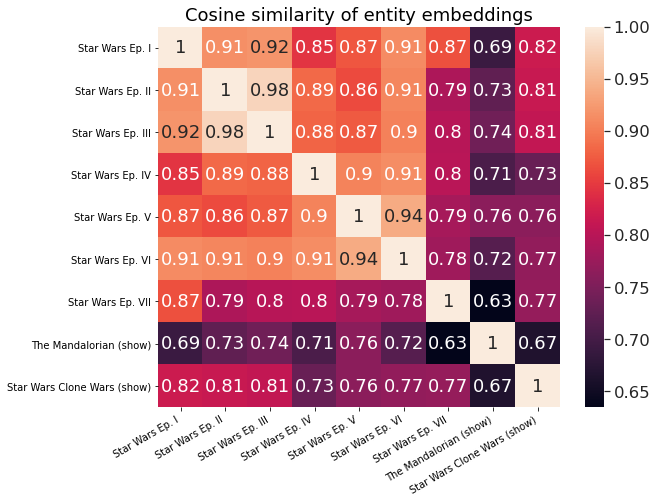

In [61]:
ent_vecs = model.wv['Q165713', 'Q181069', 'Q42051', 'Q17738', 'Q181795', 'Q181803', 'Q6074', 'Q56876444', "Q632672"]
similarity_mat = [model.wv.cosine_similarities(ent, ent_vecs) for ent in ent_vecs]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = ['Star Wars Ep. I', 'Star Wars Ep. II', 'Star Wars Ep. III', 'Star Wars Ep. IV', 'Star Wars Ep. V', 'Star Wars Ep. VI', 'Star Wars Ep. VII', 'The Mandalorian (show)', "Star Wars Clone Wars (show)"]
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of entity embeddings")
plt.show()